In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import warnings
import matplotlib.pyplot as plt

In [2]:
# Define the filenames and the samples of interest
filenames = [f'DBTL{i}.csv' for i in range(7)]

# Load CSV files and concatenate into a single dataframe
dataframes = [pd.read_csv(filename) for filename in filenames]
combined_df = pd.concat(dataframes, ignore_index=True)

In [3]:
# Load the name_df DataFrame for translation
name_df = pd.read_csv('proteomics_id_translator_240305.csv') 

# Create a dictionary from the name_df for fast lookup
translator_dict = pd.Series(name_df['locus'].values, index=name_df['extracted']).to_dict()

# Use the dictionary to map the Protein.Group names to locus names
combined_df['Protein.Group'] = combined_df['Protein.Group'].map(lambda x: translator_dict.get(x, x))

# Count the number of non-translated protein groups
nontranslated = combined_df['Protein.Group'].apply(lambda x: x not in translator_dict.values()).sum()
print(f"In total, N = {nontranslated}/{len(combined_df['Protein.Group'])} proteins were not translated to locus names")

In total, N = 19710/2544333 proteins were not translated to locus names


In [4]:
# List of samples of interest
samples_of_interest = [
    "PP_0368", "PP_0437", "PP_0528", "PP_0751","PP_0812", "PP_0813", "PP_0814",
    "PP_0815", "PP_1317", "PP_1506", "PP_2136", "PP_4120", "PP_4189",
    "PP_4191", "PP_4192"]

sample_control_pairs = {sample: "Control" for sample in samples_of_interest}

In [5]:
# Filters
log2_fold_change_threshold = 0
p_value_threshold = 0.05 
top3_filter = 0.001

In [6]:
log2_log10_results = pd.DataFrame()

# Check if the required columns exist in the dataframe
required_columns = ['Sample', 'Replicate', 'Protein.Group', '%_of protein_abundance_Top3-method']
for col in required_columns:
    if col not in combined_df.columns:
        raise KeyError(f"Column '{col}' not found in the dataframe")

replicates_to_include = ['R4', 'R5', 'R6']
for sample, control in sample_control_pairs.items():
    # Filter data for the current sample and its control
    if sample in ['PP_0812', 'PP_0813']:
        sample_data = combined_df[(combined_df['Sample'] == sample) & (combined_df['Replicate'].isin(replicates_to_include))]
    else:
        sample_data = combined_df[combined_df['Sample'] == sample]
    
    control_data = combined_df[combined_df['Sample'] == control]

    # Debug: Check if data is loaded correctly
    if sample_data.empty or control_data.empty:
        print(f"No data for {sample} or {control}")
        continue

    # Compute mean %_of protein_abundance_Top3-method for each protein
    sample_mean = sample_data.groupby('Protein.Group')['%_of protein_abundance_Top3-method'].mean().reset_index()
    control_mean = control_data.groupby('Protein.Group')['%_of protein_abundance_Top3-method'].mean().reset_index()

    # Rename columns for clarity
    sample_mean.rename(columns={'%_of protein_abundance_Top3-method': 'sample_abundance'}, inplace=True)
    control_mean.rename(columns={'%_of protein_abundance_Top3-method': 'control_abundance'}, inplace=True)
    
    # Filter reference_mean to include only abundances > top3_filter
    control_mean = control_mean[control_mean['control_abundance'] > top3_filter]

    # Merge the data on Protein.Group
    merged_data = pd.merge(sample_mean, control_mean, on='Protein.Group', how='outer')

    # Calculate log2 fold change (fill missing values with NaN)
    merged_data['log2_change'] = np.log2(merged_data['sample_abundance'] / merged_data['control_abundance'])

    # Debug: Check if log2_change contains NaN values
    if merged_data['log2_change'].isna().all():
        print(f"All log2 fold changes are NaN for {sample} vs {control}")
        continue

    # Compute p-values (assume replicates data exists for actual p-value calculation)
    sample_reps = sample_data[['Protein.Group', '%_of protein_abundance_Top3-method']]
    control_reps = control_data[['Protein.Group', '%_of protein_abundance_Top3-method']]

    p_values = []
    for protein in merged_data['Protein.Group']:
        group1 = sample_reps[sample_reps['Protein.Group'] == protein]['%_of protein_abundance_Top3-method']
        group2 = control_reps[control_reps['Protein.Group'] == protein]['%_of protein_abundance_Top3-method']
        if not group1.empty and not group2.empty:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                try:
                    _, p_val = ttest_ind(group1, group2, equal_var=False)
                except ValueError:
                    p_val = np.nan
        else:
            p_val = np.nan
        p_values.append(p_val)

    # Add p-values and log10 transformation
    merged_data['p_value'] = p_values
    merged_data['log10_p_value'] = -np.log10(merged_data['p_value'])

    # Debug: Check if log10_p_value contains NaN values
    if merged_data['log10_p_value'].isna().all():
        print(f"All log10 p-values are NaN for {sample} vs {control}")
        continue

    # Filter based on plotting criteria
    filtered_data = merged_data[
        (merged_data['log2_change'].abs() > log2_fold_change_threshold) &
        (merged_data['log10_p_value'] > -np.log10(p_value_threshold))
    ]

    # Store filtered results in log2_log10_results
    if log2_log10_results.empty:
        log2_log10_results = filtered_data[['Protein.Group', 'log2_change', 'log10_p_value']].copy()
        log2_log10_results.rename(
            columns={'log2_change': f'{sample}_log2_FC', 'log10_p_value': f'{sample}_log10_pval'},
            inplace=True
        )
    else:
        temp_results = filtered_data[['Protein.Group', 'log2_change', 'log10_p_value']].copy()
        temp_results.rename(
            columns={'log2_change': f'{sample}_log2_FC', 'log10_p_value': f'{sample}_log10_pval'},
            inplace=True
        )
        log2_log10_results = pd.merge(
            log2_log10_results,
            temp_results,
            on='Protein.Group',
            how='outer'
        )

# Save the filtered log2 and log10 values to a CSV file
log2_log10_results.to_csv('filtered_log2_log10_values_by_significance.csv', index=False)
print("Filtered Log2 and Log10 values saved to 'filtered_log2_log10_values_by_significance.csv'")

Filtered Log2 and Log10 values saved to 'filtered_log2_log10_values_by_significance.csv'


In [7]:
analysis_name = 'TCA'
# Convert the list of genes to a list
proteins_txt = pd.read_csv('pathway-genes-TCA.txt', delimiter='\t')  # Adjust the separator if needed
#proteins_txt = pd.read_csv('pathway-genes-PWY-Respiration_Full.txt', delimiter='\t')
gene_list = proteins_txt['Gene Accession'].tolist()

# Ensure there are no leading/trailing whitespaces in the gene names
log2_log10_results['Protein.Group'] = log2_log10_results['Protein.Group'].str.strip()
proteins_txt['Gene Accession'] = proteins_txt['Gene Accession'].str.strip()

# Filter the log2_log10_results to include only the proteins in the gene list
filtered_results = log2_log10_results[log2_log10_results['Protein.Group'].isin(gene_list)]
# Select only the columns that end with '_FC'
fc_columns = [col for col in filtered_results.columns if col.endswith('_FC')]
filtered_fc_results = filtered_results[['Protein.Group'] + fc_columns]

# Save the filtered results to a CSV file
filtered_fc_results.to_csv(f'{analysis_name}_fc_results.csv', index=False)
print(f"Filtered fold change results saved to '{analysis_name}_fc_results.csv'")

Filtered fold change results saved to 'TCA_fc_results.csv'


In [8]:
analysis_name = 'OxPhos'
# Convert the list of genes to a list
proteins_txt = pd.read_csv('pathway-genes-PWY-Respiration_Pooled.txt', delimiter='\t')  # Adjust the separator if needed
gene_list = proteins_txt['Gene Accession'].tolist()

# Ensure there are no leading/trailing whitespaces in the gene names
log2_log10_results['Protein.Group'] = log2_log10_results['Protein.Group'].str.strip()
proteins_txt['Gene Accession'] = proteins_txt['Gene Accession'].str.strip()

# Filter the log2_log10_results to include only the proteins in the gene list
filtered_results = log2_log10_results[log2_log10_results['Protein.Group'].isin(gene_list)]
# Select only the columns that end with '_FC'
fc_columns = [col for col in filtered_results.columns if col.endswith('_FC')]
filtered_fc_results = filtered_results[['Protein.Group'] + fc_columns]

# Save the filtered results to a CSV file
filtered_fc_results.to_csv(f'{analysis_name}_fc_results.csv', index=False)
print(f"Filtered fold change results saved to '{analysis_name}_fc_results.csv'")

Filtered fold change results saved to 'OxPhos_fc_results.csv'


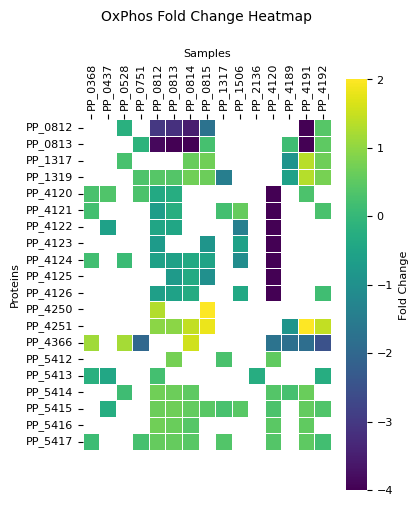

In [11]:
import seaborn as sns
analysis_name = 'OxPhos'
filtered_fc_results = pd.read_csv(f'{analysis_name}_fc_results.csv')

# Set the index to 'Protein.Group' for the heatmap
filtered_fc_results.set_index('Protein.Group', inplace=True)

# Remove the '_log2_FC' suffix from the column names
filtered_fc_results.columns = [col.replace('_log2_FC', '') for col in filtered_fc_results.columns]

# Set font properties
plt.rcParams['font.size'] = 8  # Set the font size to a smaller value

# Calculate the aspect ratio
num_rows, num_cols = filtered_fc_results.shape
aspect_ratio = num_cols / num_rows
vmin=-4
vmax=2

# Create a heatmap with the 'viridis' colormap
fig, ax = plt.subplots(figsize=(4, 4 / aspect_ratio))  # Adjust the size as needed
heatmap = sns.heatmap(filtered_fc_results, cmap='viridis', annot=False, cbar_kws={'label': 'Fold Change'}, linewidths=.5, ax=ax, square=True,vmin=vmin,vmax=vmax)

# Move the x-axis labels to the top and set them to vertical
heatmap.xaxis.set_ticks_position('top')
heatmap.xaxis.set_label_position('top')
plt.xticks(rotation=90, fontsize=8)  # Set the font size for x-axis labels
plt.yticks(fontsize=8)  # Set the font size for y-axis labels

# Add title and labels
plt.title(f'{analysis_name} Fold Change Heatmap', pad=20, fontsize=10)  # Set the font size for the title
plt.xlabel('Samples', fontsize=8)  # Set the font size for x-axis label
plt.ylabel('Proteins', fontsize=8)  # Set the font size for y-axis labe

# Save the heatmap as an image file
plt.savefig(f'{analysis_name}_fc_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.show()

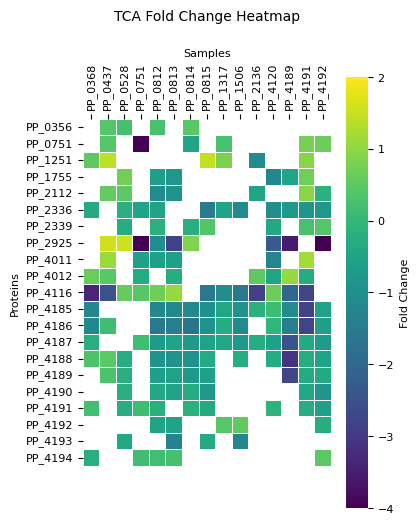

In [12]:
# Define the analysis name and load the filtered results
analysis_name = 'TCA'
filtered_fc_results = pd.read_csv(f'{analysis_name}_fc_results.csv')

# Set the index to 'Protein.Group' for the heatmap
filtered_fc_results.set_index('Protein.Group', inplace=True)

# Remove the '_log2_FC' suffix from the column names
filtered_fc_results.columns = [col.replace('_log2_FC', '') for col in filtered_fc_results.columns]

# Set font properties
plt.rcParams['font.size'] = 8  # Set the font size to a smaller value

# Calculate the aspect ratio
num_rows, num_cols = filtered_fc_results.shape
aspect_ratio = num_cols / num_rows

# Create a heatmap with the 'viridis' colormap
fig, ax = plt.subplots(figsize=(4, 4 / aspect_ratio))  # Adjust the size as needed
heatmap = sns.heatmap(filtered_fc_results, cmap='viridis', annot=False, cbar_kws={'label': 'Fold Change'}, linewidths=.5, ax=ax, square=True,vmin=vmin,vmax=vmax)

# Move the x-axis labels to the top and set them to vertical
heatmap.xaxis.set_ticks_position('top')
heatmap.xaxis.set_label_position('top')
plt.xticks(rotation=90, fontsize=8)  # Set the font size for x-axis labels
plt.yticks(fontsize=8)  # Set the font size for y-axis labels

# Add title and labels
plt.title(f'{analysis_name} Fold Change Heatmap', pad=20, fontsize=10)  # Set the font size for the title
plt.xlabel('Samples', fontsize=8)  # Set the font size for x-axis label
plt.ylabel('Proteins', fontsize=8)  # Set the font size for y-axis label

# Save the heatmap as an image file
plt.savefig(f'{analysis_name}_fc_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.show()

Filtered fold change results saved to 'FAD_FAB_fc_results.csv'


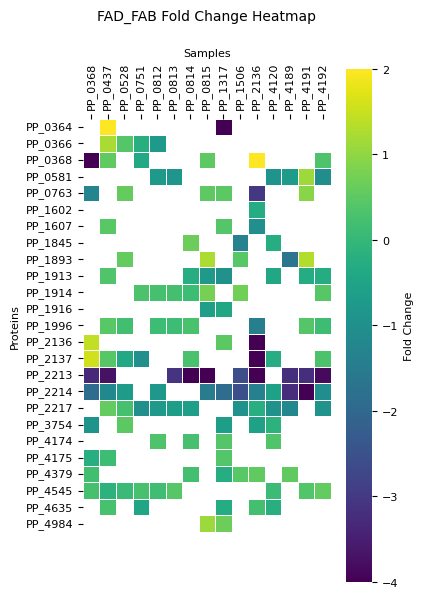

In [16]:
analysis_name = 'FAD_FAB'
# Convert the list of genes to a list
proteins_txt = pd.read_csv('FAD_FAB.txt', delimiter='\t')  # Adjust the separator if needed
#proteins_txt = pd.read_csv('pathway-genes-PWY-Respiration_Full.txt', delimiter='\t')
gene_list = proteins_txt['Gene Accession'].tolist()

# Ensure there are no leading/trailing whitespaces in the gene names
log2_log10_results['Protein.Group'] = log2_log10_results['Protein.Group'].str.strip()
proteins_txt['Gene Accession'] = proteins_txt['Gene Accession'].str.strip()

# Filter the log2_log10_results to include only the proteins in the gene list
filtered_results = log2_log10_results[log2_log10_results['Protein.Group'].isin(gene_list)]
# Select only the columns that end with '_FC'
fc_columns = [col for col in filtered_results.columns if col.endswith('_FC')]
filtered_fc_results = filtered_results[['Protein.Group'] + fc_columns]

# Save the filtered results to a CSV file
filtered_fc_results.to_csv(f'{analysis_name}_fc_results.csv', index=False)
print(f"Filtered fold change results saved to '{analysis_name}_fc_results.csv'")

# Define the analysis name and load the filtered results
analysis_name = 'FAD_FAB'
filtered_fc_results = pd.read_csv(f'{analysis_name}_fc_results.csv')

# Set the index to 'Protein.Group' for the heatmap
filtered_fc_results.set_index('Protein.Group', inplace=True)

# Remove the '_log2_FC' suffix from the column names
filtered_fc_results.columns = [col.replace('_log2_FC', '') for col in filtered_fc_results.columns]

# Set font properties
plt.rcParams['font.size'] = 8  # Set the font size to a smaller value

# Calculate the aspect ratio
num_rows, num_cols = filtered_fc_results.shape
aspect_ratio = num_cols / num_rows

# Create a heatmap with the 'viridis' colormap
fig, ax = plt.subplots(figsize=(4, 4 / aspect_ratio))  # Adjust the size as needed
heatmap = sns.heatmap(filtered_fc_results, cmap='viridis', annot=False, cbar_kws={'label': 'Fold Change'}, linewidths=.5, ax=ax, square=True,vmin=vmin,vmax=vmax)

# Move the x-axis labels to the top and set them to vertical
heatmap.xaxis.set_ticks_position('top')
heatmap.xaxis.set_label_position('top')
plt.xticks(rotation=90, fontsize=8)  # Set the font size for x-axis labels
plt.yticks(fontsize=8)  # Set the font size for y-axis labels

# Add title and labels
plt.title(f'{analysis_name} Fold Change Heatmap', pad=20, fontsize=10)  # Set the font size for the title
plt.xlabel('Samples', fontsize=8)  # Set the font size for x-axis label
plt.ylabel('Proteins', fontsize=8)  # Set the font size for y-axis label

# Save the heatmap as an image file
plt.savefig(f'{analysis_name}_fc_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.show()